In [1]:
# Please execute/shift-return this cell everytime you run the notebook.  Don't edit it. 
%load_ext autoreload
%autoreload 2
from notebook import * 

The key is already registered
Done loading notebook.py! We're good to go!


<div class="namebox">    
Double Click to edit and enter your

1.  Name: Hugo Wan
2.  PID/SID: twan012 / 862180666
3.  twan012@ucr.edu email address
    
</div>

<div style=" font-size: 300% !important;
    margin-top: 1.5em;
    margin-bottom: 10px;
    font-weight: bold;
    line-height: 1.0;
    text-align:center;">
Programming Assignment 1: Understanding the critical performance bottleneck in LLMs!
</div>

**Welcome to the first programming assignment/lab of CS203!**

The main goals of this assignment/lab are:

1. Get familiar with performance profiling tools.
2. Get familiar with C/C++ and the development environment.
 
This assignment/lab will be completed on **your own**. 

Check Gradescope for due date(s).

## Browser Compatibility

We are still working out some bugs in some browsers.  Here's the current status:

1.  Chrome -- well tested.  Preferred option.
2.  Firefox -- seems ok, but not thoroughly tested.
3.  Edge -- seems ok, but not thoroughly tested.
4.  Safari -- not supported at the moment.
5.  Internet Explorer -- not supported at the moment.

At the moment, the authentication step must be done in Chrome.

## Keeping Your assignment/lab Up-to-Date

Occasionally, there will be changes made to the base repository after the
lab is released.  This may include bug fixes and updates to this document.  We'll post on piazza/edstem when an update is available.

In those cases, you can use the following commands to pull the changes from upstream and merge them into your code.  You'll need to do this at a shell.  It won't work properly in the notebook.  Save your notebook in the browser first.


```
cd <your directory for this assignment/lab>git remote add upstream $(cat .starter_repo)  # You need to do this once each time you checkout a new assignment/lab. It will fail 
                                              # harmlessly if you run it more than once.
cp assignment-lab.ipynb assignment-lab.backup.ipynb                 # Backup your work.
git commit -am "My progress so far."          # commit your work.
git pull upstream main --allow-unrelated-histories -X theirs # pull the updates
```

Or you can use the script we provide:

In [2]:
# Be sure to click save to preseve your progress before updating
! ./fix-repo
! ./pull-updates

fatal: remote upstream already exists.
cp: cannot stat 'assignment-lab.ipynb': No such file or directory
[main 0376ebe] My progress so far.
 2 files changed, 529 insertions(+), 37 deletions(-)
From github.com:CS203UCR/2025fa-cs203-llm-starter
 * branch            main       -> FETCH_HEAD
Already up to date.


Then, reload this page in your browser.

## How To Use This Document

You will use Jupyter Notebook to complete this assignment/lab.  You should be able to do much of this assignment/lab without leaving Jupyter Notebook.  The main exception will be some of the programming chanllenges.  The instructions will make it clear when you should use the terminal.

### Running Code

Jupyter Notebooks are made up of "cells".  Some have Markdown-formatted text in them (like this one).  Some have Python code (like the one below).

For code cells, you press `shift-return` to execute the code.  Try it below:

In [3]:
print("I'm in python")

I'm in python


Code cells can also execute shell commands using the `!` operator.  Try it below:

In [4]:
!echo "I'm in a shell"

I'm in a shell


### Telling What The Notebook is Doing

The notebook will only run one cell at a time, so if you press `shift-return` several times, the cells will wait for one another.  You can tell that a cell is waiting if it there's a `*` in the `[]` to the left the cell:

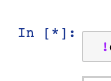


You'll can also tell _where_ the notebook is executing by looking at the table of contents on the left.  The section with the currently-executing cell will be red:

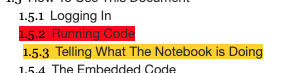

### What to Do Jupyter Notebook It Gets Stuck

First, check if it's actually stuck: Some of the cells take a while, but they will usually provide some visual sign of progress.  If _nothing_ is happening for more than 10 seconds, it's probably stuck.

To get it unstuck, you stop execution of the current cell with the "interrupt button":

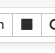

### Use VSCode

The container that we build for CSE142L provides a more friendly "VSCode" environment. To launch that environment, you should find and press the `+` icon near the file menu.

![plus.png](plus.png)

The interface will move to a launcher where you may find the following VSCode icon.

![vscode.png](vscode.png)

Press that icon and then you can enjoy VSCode environment!

# Profiling application performance

Profiling can be valuable tool in figuring out where your code is spending time. 

To profile the llm.c project, you need to recompile it with the debug flag `-g` enabled. The purpose of the flag is to insert some useful metadata, including the mapping between function names/variables/source code lines and the compiled binary.

**NOTE:** Don't forget to rebuild without the `-g` flag. BUilding in support for gprof will slow down your code a bit.

Please use the following cell to build the llm.c code with `-g` enabled.

In [5]:
! make clean; make OPT_CFLAGS="-g"

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
rm -f train_gpt2 test_gpt2
rm -f build/*.o
---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native -g   train_gpt2.c perfstats.o -lm -o train_gpt2
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native -

After generating the binary executable with debugging flag, we can run the executable using `perf record` command before the normal command line and arguments on the cloud and pipe the profiled data into a file, `perf.data` (The default profile result output file name of perf). You may we the following cell to test this.

In [6]:
! cse142 run "perf record ./test_gpt2 > perf.data"

Running on the cloud for: twan012@ucsd.edu
check /proc/sys/kernel/kptr_restrict and /proc/sys/kernel/perf_event_paranoid.

Samples in kernel functions may not be resolved if a suitable vmlinux
file is not found in the buildid cache or in the vmlinux path.

Samples in kernel modules won't be resolved at all.

If some relocation was applied (e.g. kexec) symbols may be misresolved
even with a suitable vmlinux or kallsyms file.

Couldn't record kernel reference relocation symbol
Symbol resolution may be skewed if relocation was used (e.g. kexec).
Check /proc/kallsyms permission or run as root.
[GPT-2]
max_seq_len: 1024
vocab_size: 50257
padded_vocab_size: 50304
num_layers: 12
num_heads: 12
channels: 768
num_parameters: 124475904
[State]
batch_size: 4
seq_len: 64
num_activations: 73347840
-43.431618, -43.431721
-39.836346, -39.836445
-43.065910, -43.065987
-42.828045, -42.828156
-43.529541, -43.529644
-44.318398, -44.318489
-41.227425, -41.227497
-41.270760, -41.270847
-42.541393, -42.54147

Now, we can use `perf report` to interpret the output as human-readable content using the following cell.

In [7]:
! perf report --stdio > perf.out

Kernel address maps (/proc/{kallsyms,modules}) were restricted.

Check /proc/sys/kernel/kptr_restrict before running 'perf record'.

As no suitable kallsyms nor vmlinux was found, kernel samples
can't be resolved.

Samples in kernel modules can't be resolved as well.



The output file is really long, and the goal is never about optimizing everything. So we can use `head` command to see what's in the first 20 lines of the output.

In [8]:
! head -20 perf.out

# To display the perf.data header info, please use --header/--header-only options.
#
#
# Total Lost Samples: 0
#
# Samples: 657K of event 'cycles'
# Event count (approx.): 576483603880
#
# Overhead  Command    Shared Object     Symbol                          
# ........  .........  ................  ................................
#
    49.39%  test_gpt2  test_gpt2         [.] matmul_backward
    29.16%  test_gpt2  test_gpt2         [.] gpt2_backward
     8.08%  test_gpt2  test_gpt2         [.] matmul_forward
     4.43%  test_gpt2  test_gpt2         [.] gpt2_forward
     1.97%  test_gpt2  libm-2.31.so      [.] __expm1f
     1.45%  test_gpt2  test_gpt2         [.] attention_backward
     0.98%  test_gpt2  test_gpt2         [.] gpt2_update
     0.71%  test_gpt2  libm-2.31.so      [.] __tanhf
     0.47%  test_gpt2  [unknown]         [k] 0xffffffff89d0cdb5


Have you find which function takes the most significant amount of time?

<div class="alert alert-block alert-danger">
    
What's the most time consuming function?
    
    
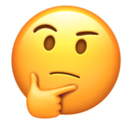
</div>

In [9]:
# Fill the name of the function here

most_time_consuming_function =  "matmul_backward"

# Programming Assignment

The assignments will all have a programming assignment as part of them.  The main purpose of this one is to get you familiar with the autograding submission process.  It doesn't require any challenging programming.

In the assignment directory, you'll find `train_gpt2.h`, and now, we use the `render_code` notebook function to show the content of `matmul_forward` function.

In [10]:
render_code("train_gpt2.h", show="matmul_forward")

// train_gpt2.h:165-178 (14 lines)
    // unfriendly input shapes inside matmul_forward(), below.
    for (int b = 0; b < B; b++) {
        for (int t = 0; t < T; t++) {
            int bt = b * T + t;
            for (int o = 0; o < OC; o++) {
                float val = (bias != NULL) ? bias[o] : 0.0f;
                for (int i = 0; i < C; i++) {
                    val += inp[bt * C + i] * weight[o*C + i];
                }
                out[bt * OC + o] = val;
            }
        }
    }
}

Can you modify the following cell to show the content of the most time-consuming function?

In [11]:
render_code("train_gpt2.h", show=most_time_consuming_function)

// train_gpt2.h:226-263 (38 lines)
void matmul_backward(float* dinp, float* dweight, float* dbias,
                     const float* dout, const float* inp, const float* weight,
                     int B, int T, int C, int OC) {
    // most of the running time is spent here and in matmul_forward
    // this backward could be done in a single "round" of loops
    // but that doesn't afford an efficient parallelization strategy
    // backward into inp first, parallelize over B,T

    for (int b = 0; b < B; b++) {
        for (int t = 0; t < T; t++) {
            const float* dout_bt = dout + b * T * OC + t * OC;
            float* dinp_bt = dinp + b * T * C + t * C;
            for (int o = 0; o < OC; o++) {
                const float* wrow = weight + o*C;
                float d = dout_bt[o];
                for (int i = 0; i < C; i++) {
                    dinp_bt[i] += wrow[i] * d;
                }
            }
        }
    }
    // backward into weight/bias, parallelize over output channels OC
    for (int o = 0; o < OC; o++) {
        for (int b = 0; b < B; b++) {
            for (int t = 0; t < T; t++) {
                const float* dout_bt = dout + b * T * OC + t * OC;
                const float* inp_bt = inp + b * T * C + t * C;
                float* dwrow = dweight + o*C;
                float d = dout_bt[o];
                if (dbias != NULL) { dbias[o] += d; }
                for (int i = 0; i < C; i++) {
                    dwrow[i] += inp_bt[i] * d;
                }
            }
        }
    }

}

Now, within the most time-consuming function, can you insert this line of code at the entrance of the function?

```
printf("%s\n", __func__);
```

If you do it right, you will see the function name of the identified most time-consuming function printed many many times when running the following command.

In [12]:
!make test_gpt2
!cse142 run "./test_gpt2"

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native    test_gpt2.c perfstats.o -lm -o test_gpt2
Running on the cloud for: twan012@ucsd.edu
[GPT-2]
max_seq_len: 1024
vocab_size: 50257
padded_vocab_size: 50304
num_layers: 12
num_heads: 12
channels: 768
num_parameters: 124475904
[State]
batch_size: 4
seq_len: 64
num_activations: 73347840
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmul_backward
matmu

Now, edit the `print_my_name` function in `train_gpt2.h` so that we can see the following output exactly once at the end of the execution! 
```
Trained by <your @ucr.edu email address>!
```
You can test it again on the cloud with:

In [13]:
!make test_gpt2
!cse142 run "./test_gpt2 > test_gpt2.txt"

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native    test_gpt2.c perfstats.o -lm -o test_gpt2
Running on the cloud for: twan012@ucsd.edu


When your submit your code for autograding, it'll run in a more tightly controlled way that let's us reliably measure performance and grade your submission. You can simulate it like this:

In [14]:
!cse142 run "./autograde.py  --submission . --results -"

Running on the cloud for: twan012@ucsd.edu
{
    "output": "The autograder ran.",
    "stdout_visibility": "visible",
    "tests": [
        {
            "max_score": 100,
            "number": "1",
            "output": "",
            "score": 100.0,
            "tags": [],
            "visibility": "visible"
        }
    ],
    "visibility": "visible"
}

If you ran the original code, it gets zero points (`"score": 0`).  Once you correctly modify `train_gpt2.h`, you'll get 100 point.

Once you are happy with your code, commit your changes to ``train_gpt2.h`.  You'll have to do this to turn it for official autograding.

In [19]:
!git commit -m "Yay! I finished the first assignment!" train_gpt2.h
!git push

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   assignment.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


**If this asks you for a password, it means you forgot some initial steps in the README.md file of this repo. You'll need to interrupt your Jupyter notebook kernel and follow the exact steps in the README.md before you can start again.**

If `git commit` tell you something like:

*** Please tell me who you are.

Run
```
git config --global user.email "you@example.com"
git config --global user.name "Your Name"
```
to set your account's default identity.
Omit `--global` to set the identity only in this repository.
```
fatal: unable to auto-detect email address (got 'prcheng@dsmlp-jupyter-prcheng.(none)')
Warning: Permanently added the RSA host key for IP address '140.82.112.3' to the list of known hosts.
Everything up-to-date
```
Then you can use a terminal and type in those commands to set this information correctly (but fill in your @ucr.edu email and your name).


<div class="alert alert-block alert-success">

<div class="question-text">

### References used in the project    

We do not expect everyone to know the answers at the very beginning and looking for resources to solve problems is a common practice in engineering. However, it is also important to know what can you use in these assignments and give them good enough credits through citations! 

In real practice, not everything online can be used due to the copyright and licensing issues. Therefore, it is a nice habit to keep track of your references all the time and review if they're eligible.
    
In CS203, you're allowed to seek for help from the following **independently**.

1. Public code repositories with proper license (e.g. MIT license) -- please provide the repos.
2. Research papers/textbooks -- please cite them below.
3. Generative AI -- please describe the prompt you used.
    
In contrast, you're **NOT allowed** to seek for help from the following.
1. Using code from others
2. Asking and discussing with other people except for teaching staffs.

</div>
</div>

<div class="alert alert-block alert-success">
<div class="answer">

If you have used any outside resource to finish the programming assignment, please cite each of them properly below. Without citation to the resources you used, we will consider your assignment cheating if we found similar somewhere else.

</div>
</div>

# Turning in the programming assignment


You need to turn in your notebook and your programming assignment/lab in the specific gradescope item.  
After you complete the assignment/lab, you will turn it in by submitting your latest github repository.

**Step 1:**  Save your workbook!!!

In [16]:
!for i in 1 2 3 4 5; do echo Save your files!!; sleep 1; done

Save your files!!
Save your files!!
Save your files!!
Save your files!!
Save your files!!


**Step 2:**  Run this command:

In [17]:
!cs203 turnin assignment.ipynb
!ls -lh assignment.turnin.ipynb

Wrote to assignment.turnin.ipynb
-rw-r--r-- 1 twan012 ucr 3.2K Sep 29  2025 assignment.turnin.ipynb


**Step 3:**  Commit everything. Please run the following command.

In [18]:
!git add -f assignment.turnin.ipynb
!git commit -am "Yay! I am ready to turn in!"
!git push

[main a979526] Yay! I am ready to turn in!
 1 file changed, 108 insertions(+)
 create mode 100644 assignment.turnin.ipynb
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 20 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.60 KiB | 820.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:CS203UCR/2025fa-cs203-llm-perf-HugoWan0504.git
   8a70970..a979526  main -> main


**Step 4**: 
Submit through gradescope
You'll turn in your programming assignment by providing gradescope with your github repo of this assignment.   It'll run the autograder and return the results.

If `git commit` tell you something like:

*** Please tell me who you are.

Run
```
git config --global user.email "you@example.com"
git config --global user.name "Your Name"
```
to set your account's default identity.
Omit `--global` to set the identity only in this repository.
```
fatal: unable to auto-detect email address (got 'prcheng@dsmlp-jupyter-prcheng.(none)')
Warning: Permanently added the RSA host key for IP address '140.82.112.3' to the list of known hosts.
Everything up-to-date
```
Then you can use a terminal and type in those commands to set this information correctly (but fill in your @ucsd.edu email and your name).
